# İlk Besli

In [1]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss
from sklearn.decomposition import PCA
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
import nltk
from transformers import AutoTokenizer

nltk.download('punkt')

# Veri kümesini yükle
dataset = load_dataset("Metin/WikiRAG-TR")

# Chunk ve soru ayrıştırma
chunks = []
correct_chunk_indices = []
questions = []

for i, example in enumerate(dataset['train']):
    question_chunks = example['context'].split("\n")
    correct_index = example['correct_intro_idx']

    if len(question_chunks) == 5:
        chunks.extend(question_chunks)
        correct_chunk_indices.append(len(questions)*5 + correct_index)
        questions.append(example['question'])
    elif len(question_chunks) == 6:
        if correct_index < 5:
            selected_chunks = question_chunks[:5]
        else:
            selected_chunks = question_chunks[1:]
        if question_chunks[correct_index] not in selected_chunks:
            selected_chunks[-1] = question_chunks[correct_index]
        chunks.extend(selected_chunks)
        correct_chunk_indices.append(len(questions)*5 + selected_chunks.index(question_chunks[correct_index]))
        questions.append(example['question'])

selected_questions = questions[:1000]
selected_chunks = chunks[:5000]
selected_correct_indices = correct_chunk_indices[:1000]

print(f"Seçilen 1000 soru ve 5000 chunk hazırlandı.")

# Dense Representation Modelleri
models = {
    "multilingual_e5": SentenceTransformer('intfloat/multilingual-e5-base'),
    "bge_m3": SentenceTransformer('BAAI/bge-m3'),
    "snowflake-l-v2.0": SentenceTransformer('Snowflake/snowflake-arctic-embed-l-v2.0')
}

target_dim = 768  # Ortak boyut
model_results = {}

# --- Dense Modeller ---
for model_name, model in models.items():
    print(f"{model_name} için embedding hesaplanıyor...")
    c_emb = model.encode(selected_chunks, convert_to_tensor=False, show_progress_bar=True)
    q_emb = model.encode(selected_questions, convert_to_tensor=False, show_progress_bar=True)

    # PCA uygulama
    pca = PCA(n_components=target_dim)
    c_emb = pca.fit_transform(c_emb)
    q_emb = pca.transform(q_emb)

    # FAISS index
    d = c_emb.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(c_emb)

    # Retrieval
    print(f"{model_name} için retrieval işlemi başlatıldı...")
    distances, retrieved_indices = index.search(np.array(q_emb), k=5)

    # Performans Ölçümü
    top_1_correct = 0
    top_5_correct = 0
    for i, indices in enumerate(retrieved_indices):
        if selected_correct_indices[i] in indices[:1]:
            top_1_correct += 1
        if selected_correct_indices[i] in indices:
            top_5_correct += 1

    model_results[model_name] = {
        "retrieved_indices": retrieved_indices,
        "top_1_accuracy": top_1_correct / len(selected_questions),
        "top_5_accuracy": top_5_correct / len(selected_questions)
    }

# --- BM25 (normal word tokenization) ---
print("BM25 (word tokenization) için retrieval işlemi başlatılıyor...")
tokenized_chunks_word = [word_tokenize(chunk.lower()) for chunk in selected_chunks]
bm25_word = BM25Okapi(tokenized_chunks_word)

bm25_word_all_indices = []
top_1_correct = 0
top_5_correct = 0
for i, question in enumerate(selected_questions):
    tokenized_question = word_tokenize(question.lower())
    scores = bm25_word.get_scores(tokenized_question)
    bm25_indices = np.argsort(scores)[::-1][:5]
    bm25_word_all_indices.append(bm25_indices)

    if selected_correct_indices[i] in bm25_indices[:1]:
        top_1_correct += 1
    if selected_correct_indices[i] in bm25_indices:
        top_5_correct += 1

model_results["bm25_word"] = {
    "retrieved_indices": np.array(bm25_word_all_indices),
    "top_1_accuracy": top_1_correct / len(selected_questions),
    "top_5_accuracy": top_5_correct / len(selected_questions)
}

# --- BM25 (BERT tokenization) ---
print("BM25 (BERT tokenization) için retrieval işlemi başlatılıyor...")

# BERT tokenizer ile tokenize et
bert_tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

def bert_tokenize(text):
    # tokenizer çıktısındaki 'input_ids'leri alıp tekrar kelime haline getirmek yerine
    # doğrudan tokenizer.convert_ids_to_tokens kullandık.
    tokens = bert_tokenizer.tokenize(text.lower())
    return tokens

tokenized_chunks_bert = [bert_tokenize(chunk) for chunk in selected_chunks]
bm25_bert = BM25Okapi(tokenized_chunks_bert)

bm25_bert_all_indices = []
top_1_correct = 0
top_5_correct = 0
for i, question in enumerate(selected_questions):
    tokenized_question_bert = bert_tokenize(question)
    scores = bm25_bert.get_scores(tokenized_question_bert)
    bm25_indices = np.argsort(scores)[::-1][:5]
    bm25_bert_all_indices.append(bm25_indices)

    if selected_correct_indices[i] in bm25_indices[:1]:
        top_1_correct += 1
    if selected_correct_indices[i] in bm25_indices:
        top_5_correct += 1

model_results["bm25_bert"] = {
    "retrieved_indices": np.array(bm25_bert_all_indices),
    "top_1_accuracy": top_1_correct / len(selected_questions),
    "top_5_accuracy": top_5_correct / len(selected_questions)
}

# Tekil yöntem sonuçları
for model_name, results in model_results.items():
    print(f"{model_name} - Top-1 Accuracy: {results['top_1_accuracy']:.4f}, Top-5 Accuracy: {results['top_5_accuracy']:.4f}")

# Ensemble (Tüm dense'ler + BM25 (word) + BM25 (bert))
methods = list(model_results.keys())  # ["multilingual_e5", "bge_m3", "snowflake-l-v2.0", "bm25_word", "bm25_bert"]

top_1_correct = 0
top_5_correct = 0

for i in range(len(selected_questions)):
    chunk_scores = {}
    for method in methods:
        retrieved_indices = model_results[method]["retrieved_indices"][i]
        for rank, c_idx in enumerate(retrieved_indices):
            score = 5 - rank  # top-1: 5 puan, top-2:4 ... top-5:1
            if c_idx not in chunk_scores:
                chunk_scores[c_idx] = 0
            chunk_scores[c_idx] += score

    sorted_chunks = sorted(chunk_scores.items(), key=lambda x: x[1], reverse=True)
    top_chunks = [x[0] for x in sorted_chunks[:5]]

    if selected_correct_indices[i] in top_chunks[:1]:
        top_1_correct += 1
    if selected_correct_indices[i] in top_chunks:
        top_5_correct += 1

ensemble_top_1_acc = top_1_correct / len(selected_questions)
ensemble_top_5_acc = top_5_correct / len(selected_questions)

print(f"Ensemble (Tüm 5 temsil) - Top-1 Accuracy: {ensemble_top_1_acc:.4f}, Top-5 Accuracy: {ensemble_top_5_acc:.4f}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Seçilen 1000 soru ve 5000 chunk hazırlandı.
multilingual_e5 için embedding hesaplanıyor...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

multilingual_e5 için retrieval işlemi başlatıldı...
bge_m3 için embedding hesaplanıyor...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

bge_m3 için retrieval işlemi başlatıldı...
snowflake-l-v2.0 için embedding hesaplanıyor...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

snowflake-l-v2.0 için retrieval işlemi başlatıldı...
BM25 (word tokenization) için retrieval işlemi başlatılıyor...
BM25 (BERT tokenization) için retrieval işlemi başlatılıyor...


Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


multilingual_e5 - Top-1 Accuracy: 0.3310, Top-5 Accuracy: 0.5330
bge_m3 - Top-1 Accuracy: 0.3350, Top-5 Accuracy: 0.5330
snowflake-l-v2.0 - Top-1 Accuracy: 0.3170, Top-5 Accuracy: 0.5290
bm25_word - Top-1 Accuracy: 0.2220, Top-5 Accuracy: 0.4010
bm25_bert - Top-1 Accuracy: 0.2930, Top-5 Accuracy: 0.4970
Ensemble (Tüm 5 temsil) - Top-1 Accuracy: 0.3260, Top-5 Accuracy: 0.5320


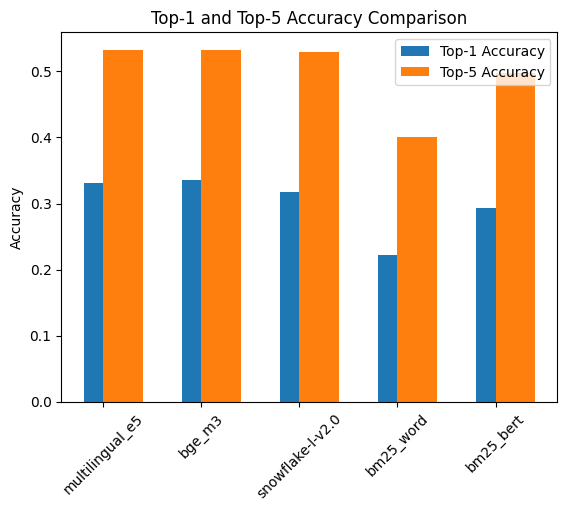

In [3]:
import matplotlib.pyplot as plt

# Top-1 ve Top-5 doğrulukları
models = list(model_results.keys())
top_1_accuracies = [model_results[model]["top_1_accuracy"] for model in models]
top_5_accuracies = [model_results[model]["top_5_accuracy"] for model in models]

# Çubuk grafik
x = range(len(models))
plt.bar(x, top_1_accuracies, width=0.4, label="Top-1 Accuracy", align='center')
plt.bar(x, top_5_accuracies, width=0.4, label="Top-5 Accuracy", align='edge')
plt.xticks(x, models, rotation=45)
plt.ylabel("Accuracy")
plt.title("Top-1 and Top-5 Accuracy Comparison")
plt.legend()
plt.show()


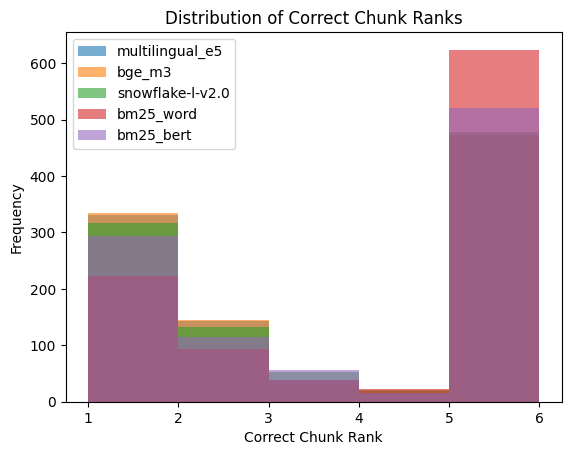

In [4]:
for model_name, results in model_results.items():
    correct_ranks = []
    for i, indices in enumerate(results["retrieved_indices"]):
        rank = np.where(indices == selected_correct_indices[i])[0]
        correct_ranks.append(rank[0] + 1 if len(rank) > 0 else len(indices) + 1)
    
    plt.hist(correct_ranks, bins=range(1, 7), alpha=0.6, label=model_name)

plt.xlabel("Correct Chunk Rank")
plt.ylabel("Frequency")
plt.title("Distribution of Correct Chunk Ranks")
plt.legend()
plt.show()


# İkinci Besli

In [9]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import nltk
from transformers import AutoTokenizer

nltk.download('punkt')

# Veri kümesini yükle
dataset = load_dataset("Metin/WikiRAG-TR")

# Chunk ve soru ayrıştırma
chunks = []
correct_chunk_indices = []
questions = []

for i, example in enumerate(dataset['train']):
    question_chunks = example['context'].split("\n")
    correct_index = example['correct_intro_idx']

    if len(question_chunks) == 5:
        chunks.extend(question_chunks)
        correct_chunk_indices.append(len(questions)*5 + correct_index)
        questions.append(example['question'])
    elif len(question_chunks) == 6:
        if correct_index < 5:
            selected_chunks = question_chunks[:5]
        else:
            selected_chunks = question_chunks[1:]
        if question_chunks[correct_index] not in selected_chunks:
            selected_chunks[-1] = question_chunks[correct_index]
        chunks.extend(selected_chunks)
        correct_chunk_indices.append(len(questions)*5 + selected_chunks.index(question_chunks[correct_index]))
        questions.append(example['question'])

selected_questions = questions[:1000]
selected_chunks = chunks[:5000]
selected_correct_indices = correct_chunk_indices[:1000]

print(f"Seçilen 1000 soru ve 5000 chunk hazırlandı.")

# Dense Representation Modelleri
models = {
    "e5_large": SentenceTransformer('intfloat/e5-large-v2'),    
    "LaBSE": SentenceTransformer('sentence-transformers/LaBSE'),
    "instructor": SentenceTransformer('hkunlp/instructor-large')
}

target_dim = 768  # Ortak boyut
model_results = {}

# --- Dense Modeller ---
for model_name, model in models.items():
    print(f"{model_name} için embedding hesaplanıyor...")
    c_emb = model.encode(selected_chunks, convert_to_tensor=False, show_progress_bar=True)
    q_emb = model.encode(selected_questions, convert_to_tensor=False, show_progress_bar=True)

    # PCA uygulama
    pca = PCA(n_components=target_dim)
    c_emb = pca.fit_transform(c_emb)
    q_emb = pca.transform(q_emb)

    # FAISS index
    d = c_emb.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(c_emb)

    # Retrieval
    print(f"{model_name} için retrieval işlemi başlatıldı...")
    distances, retrieved_indices = index.search(np.array(q_emb), k=5)

    # Performans Ölçümü
    top_1_correct = 0
    top_5_correct = 0
    for i, indices in enumerate(retrieved_indices):
        if selected_correct_indices[i] in indices[:1]:
            top_1_correct += 1
        if selected_correct_indices[i] in indices:
            top_5_correct += 1

    model_results[model_name] = {
        "retrieved_indices": retrieved_indices,
        "top_1_accuracy": top_1_correct / len(selected_questions),
        "top_5_accuracy": top_5_correct / len(selected_questions)
    }

# --- TF-IDF (normal word tokenization) ---
print("TF-IDF (word tokenization) için retrieval işlemi başlatılıyor...")
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(selected_chunks)

tfidf_all_indices = []
top_1_correct = 0
top_5_correct = 0
for i, question in enumerate(selected_questions):
    query_vector = vectorizer.transform([question])
    scores = np.dot(tfidf_matrix, query_vector.T).toarray().flatten()
    tfidf_indices = np.argsort(scores)[::-1][:5]
    tfidf_all_indices.append(tfidf_indices)

    if selected_correct_indices[i] in tfidf_indices[:1]:
        top_1_correct += 1
    if selected_correct_indices[i] in tfidf_indices:
        top_5_correct += 1

model_results["tfidf_word"] = {
    "retrieved_indices": np.array(tfidf_all_indices),
    "top_1_accuracy": top_1_correct / len(selected_questions),
    "top_5_accuracy": top_5_correct / len(selected_questions)
}

# --- TF-IDF (BERT tokenization) ---
print("TF-IDF (BERT tokenization) için retrieval işlemi başlatılıyor...")

# BERT tokenizer ile tokenize et
bert_tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

def bert_tokenize(text):
    tokens = bert_tokenizer.tokenize(text.lower())
    return " ".join(tokens)

tokenized_chunks_bert = [bert_tokenize(chunk) for chunk in selected_chunks]
vectorizer_bert = TfidfVectorizer()
tfidf_matrix_bert = vectorizer_bert.fit_transform(tokenized_chunks_bert)

bert_tfidf_all_indices = []
top_1_correct = 0
top_5_correct = 0
for i, question in enumerate(selected_questions):
    tokenized_question_bert = bert_tokenize(question)
    query_vector_bert = vectorizer_bert.transform([tokenized_question_bert])
    scores = np.dot(tfidf_matrix_bert, query_vector_bert.T).toarray().flatten()
    tfidf_indices = np.argsort(scores)[::-1][:5]
    bert_tfidf_all_indices.append(tfidf_indices)

    if selected_correct_indices[i] in tfidf_indices[:1]:
        top_1_correct += 1
    if selected_correct_indices[i] in tfidf_indices:
        top_5_correct += 1

model_results["tfidf_bert"] = {
    "retrieved_indices": np.array(bert_tfidf_all_indices),
    "top_1_accuracy": top_1_correct / len(selected_questions),
    "top_5_accuracy": top_5_correct / len(selected_questions)
}

# Tekil yöntem sonuçları
for model_name, results in model_results.items():
    print(f"{model_name} - Top-1 Accuracy: {results['top_1_accuracy']:.4f}, Top-5 Accuracy: {results['top_5_accuracy']:.4f}")

# Ensemble (Tüm dense'ler + TF-IDF (word) + TF-IDF (bert))
methods = list(model_results.keys())  # ["e5_large", "LaBSE", "instructor-large","tfidf_word", "tfidf_bert"]

top_1_correct = 0
top_5_correct = 0

for i in range(len(selected_questions)):
    chunk_scores = {}
    for method in methods:
        retrieved_indices = model_results[method]["retrieved_indices"][i]
        for rank, c_idx in enumerate(retrieved_indices):
            score = 5 - rank  # top-1: 5 puan, top-2:4 ... top-5:1
            if c_idx not in chunk_scores:
                chunk_scores[c_idx] = 0
            chunk_scores[c_idx] += score

    sorted_chunks = sorted(chunk_scores.items(), key=lambda x: x[1], reverse=True)
    top_chunks = [x[0] for x in sorted_chunks[:5]]

    if selected_correct_indices[i] in top_chunks[:1]:
        top_1_correct += 1
    if selected_correct_indices[i] in top_chunks:
        top_5_correct += 1

ensemble_top_1_acc = top_1_correct / len(selected_questions)
ensemble_top_5_acc = top_5_correct / len(selected_questions)

print(f"Ensemble (Tüm 5 temsil) - Top-1 Accuracy: {ensemble_top_1_acc:.4f}, Top-5 Accuracy: {ensemble_top_5_acc:.4f}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Seçilen 1000 soru ve 5000 chunk hazırlandı.
e5_large için embedding hesaplanıyor...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

e5_large için retrieval işlemi başlatıldı...
LaBSE için embedding hesaplanıyor...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

LaBSE için retrieval işlemi başlatıldı...
instructor için embedding hesaplanıyor...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

instructor için retrieval işlemi başlatıldı...
TF-IDF (word tokenization) için retrieval işlemi başlatılıyor...
TF-IDF (BERT tokenization) için retrieval işlemi başlatılıyor...


Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


e5_large - Top-1 Accuracy: 0.2620, Top-5 Accuracy: 0.4540
LaBSE - Top-1 Accuracy: 0.2460, Top-5 Accuracy: 0.4150
instructor - Top-1 Accuracy: 0.2290, Top-5 Accuracy: 0.3880
tfidf_word - Top-1 Accuracy: 0.2860, Top-5 Accuracy: 0.4590
tfidf_bert - Top-1 Accuracy: 0.2710, Top-5 Accuracy: 0.4740
Ensemble (Tüm 5 temsil) - Top-1 Accuracy: 0.3170, Top-5 Accuracy: 0.5100


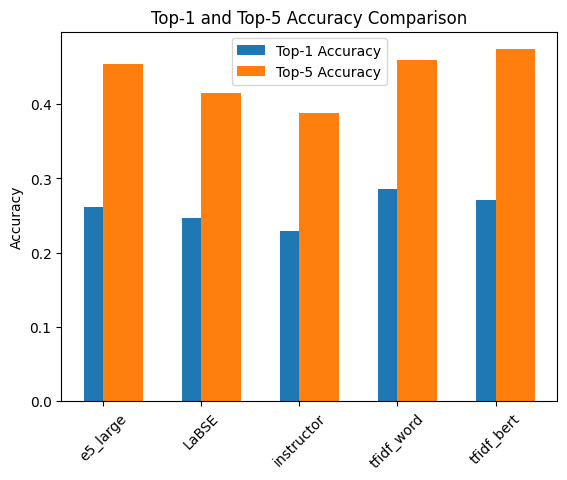

In [10]:
import matplotlib.pyplot as plt

# Top-1 ve Top-5 doğrulukları
models = list(model_results.keys())
top_1_accuracies = [model_results[model]["top_1_accuracy"] for model in models]
top_5_accuracies = [model_results[model]["top_5_accuracy"] for model in models]

# Çubuk grafik
x = range(len(models))
plt.bar(x, top_1_accuracies, width=0.4, label="Top-1 Accuracy", align='center')
plt.bar(x, top_5_accuracies, width=0.4, label="Top-5 Accuracy", align='edge')
plt.xticks(x, models, rotation=45)
plt.ylabel("Accuracy")
plt.title("Top-1 and Top-5 Accuracy Comparison")
plt.legend()
plt.show()


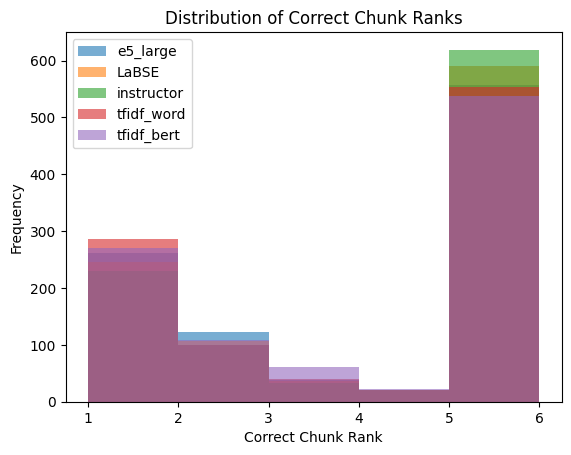

In [11]:
for model_name, results in model_results.items():
    correct_ranks = []
    for i, indices in enumerate(results["retrieved_indices"]):
        rank = np.where(indices == selected_correct_indices[i])[0]
        correct_ranks.append(rank[0] + 1 if len(rank) > 0 else len(indices) + 1)
    
    plt.hist(correct_ranks, bins=range(1, 7), alpha=0.6, label=model_name)

plt.xlabel("Correct Chunk Rank")
plt.ylabel("Frequency")
plt.title("Distribution of Correct Chunk Ranks")
plt.legend()
plt.show()


# Ucuncu Besli

In [13]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
import nltk
from transformers import AutoTokenizer

nltk.download('punkt')

# Veri kümesini yükle
dataset = load_dataset("Metin/WikiRAG-TR")

# Chunk ve soru ayrıştırma
chunks = []
correct_chunk_indices = []
questions = []

for i, example in enumerate(dataset['train']):
    question_chunks = example['context'].split("\n")
    correct_index = example['correct_intro_idx']

    if len(question_chunks) == 5:
        chunks.extend(question_chunks)
        correct_chunk_indices.append(len(questions)*5 + correct_index)
        questions.append(example['question'])
    elif len(question_chunks) == 6:
        if correct_index < 5:
            selected_chunks = question_chunks[:5]
        else:
            selected_chunks = question_chunks[1:]
        if question_chunks[correct_index] not in selected_chunks:
            selected_chunks[-1] = question_chunks[correct_index]
        chunks.extend(selected_chunks)
        correct_chunk_indices.append(len(questions)*5 + selected_chunks.index(question_chunks[correct_index]))
        questions.append(example['question'])

selected_questions = questions[:1000]
selected_chunks = chunks[:5000]
selected_correct_indices = correct_chunk_indices[:1000]

print(f"Seçilen 1000 soru ve 5000 chunk hazırlandı.")

# Dense Representation Modelleri
models = {
    "roberta": SentenceTransformer('sentence-transformers/all-roberta-large-v1'),
    "jina": SentenceTransformer('Thaweewat/jina-embedding-v3-m2v-1024'),
    "turkish_bert": SentenceTransformer('dbmdz/bert-base-turkish-cased')
}

target_dim = 768  # Ortak boyut
model_results = {}

# --- Dense Modeller ---
for model_name, model in models.items():
    print(f"{model_name} için embedding hesaplanıyor...")
    c_emb = model.encode(selected_chunks, convert_to_tensor=False, show_progress_bar=True)
    q_emb = model.encode(selected_questions, convert_to_tensor=False, show_progress_bar=True)

    # PCA uygulama
    pca = PCA(n_components=target_dim)
    c_emb = pca.fit_transform(c_emb)
    q_emb = pca.transform(q_emb)

    # FAISS index
    d = c_emb.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(c_emb)

    # Retrieval
    print(f"{model_name} için retrieval işlemi başlatıldı...")
    distances, retrieved_indices = index.search(np.array(q_emb), k=5)

    # Performans Ölçümü
    top_1_correct = 0
    top_5_correct = 0
    for i, indices in enumerate(retrieved_indices):
        if selected_correct_indices[i] in indices[:1]:
            top_1_correct += 1
        if selected_correct_indices[i] in indices:
            top_5_correct += 1

    model_results[model_name] = {
        "retrieved_indices": retrieved_indices,
        "top_1_accuracy": top_1_correct / len(selected_questions),
        "top_5_accuracy": top_5_correct / len(selected_questions)
    }

# --- Jaccard Similarity (normal word tokenization) ---
print("Jaccard Similarity (word tokenization) için retrieval işlemi başlatılıyor...")

def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

jaccard_all_indices_word = []
top_1_correct = 0
top_5_correct = 0
for i, question in enumerate(selected_questions):
    tokenized_question = set(word_tokenize(question.lower()))
    scores = []
    for chunk in selected_chunks:
        tokenized_chunk = set(word_tokenize(chunk.lower()))
        scores.append(jaccard_similarity(tokenized_question, tokenized_chunk))
    jaccard_indices = np.argsort(scores)[::-1][:5]
    jaccard_all_indices_word.append(jaccard_indices)

    if selected_correct_indices[i] in jaccard_indices[:1]:
        top_1_correct += 1
    if selected_correct_indices[i] in jaccard_indices:
        top_5_correct += 1

model_results["jaccard_word"] = {
    "retrieved_indices": np.array(jaccard_all_indices_word),
    "top_1_accuracy": top_1_correct / len(selected_questions),
    "top_5_accuracy": top_5_correct / len(selected_questions)
}

# --- Jaccard Similarity (BERT tokenization) ---
print("Jaccard Similarity (BERT tokenization) için retrieval işlemi başlatılıyor...")

# BERT tokenizer ile tokenize et
bert_tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

def bert_tokenize(text):
    tokens = set(bert_tokenizer.tokenize(text.lower()))
    return tokens

jaccard_all_indices_bert = []
top_1_correct = 0
top_5_correct = 0
for i, question in enumerate(selected_questions):
    tokenized_question_bert = bert_tokenize(question)
    scores = []
    for chunk in selected_chunks:
        tokenized_chunk_bert = bert_tokenize(chunk)
        scores.append(jaccard_similarity(tokenized_question_bert, tokenized_chunk_bert))
    jaccard_indices = np.argsort(scores)[::-1][:5]
    jaccard_all_indices_bert.append(jaccard_indices)

    if selected_correct_indices[i] in jaccard_indices[:1]:
        top_1_correct += 1
    if selected_correct_indices[i] in jaccard_indices:
        top_5_correct += 1

model_results["jaccard_bert"] = {
    "retrieved_indices": np.array(jaccard_all_indices_bert),
    "top_1_accuracy": top_1_correct / len(selected_questions),
    "top_5_accuracy": top_5_correct / len(selected_questions)
}

# Tekil yöntem sonuçları
for model_name, results in model_results.items():
    print(f"{model_name} - Top-1 Accuracy: {results['top_1_accuracy']:.4f}, Top-5 Accuracy: {results['top_5_accuracy']:.4f}")

# Ensemble (Tüm dense'ler + Jaccard (word) + Jaccard (bert))
methods = list(model_results.keys())  # ["roberta", "jina", "turkish_bert","jaccard_word", "jaccard_bert"]

top_1_correct = 0
top_5_correct = 0

for i in range(len(selected_questions)):
    chunk_scores = {}
    for method in methods:
        retrieved_indices = model_results[method]["retrieved_indices"][i]
        for rank, c_idx in enumerate(retrieved_indices):
            score = 5 - rank  # top-1: 5 puan, top-2:4 ... top-5:1
            if c_idx not in chunk_scores:
                chunk_scores[c_idx] = 0
            chunk_scores[c_idx] += score

    sorted_chunks = sorted(chunk_scores.items(), key=lambda x: x[1], reverse=True)
    top_chunks = [x[0] for x in sorted_chunks[:5]]

    if selected_correct_indices[i] in top_chunks[:1]:
        top_1_correct += 1
    if selected_correct_indices[i] in top_chunks:
        top_5_correct += 1

ensemble_top_1_acc = top_1_correct / len(selected_questions)
ensemble_top_5_acc = top_5_correct / len(selected_questions)

print(f"Ensemble (Tüm 5 temsil) - Top-1 Accuracy: {ensemble_top_1_acc:.4f}, Top-5 Accuracy: {ensemble_top_5_acc:.4f}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Seçilen 1000 soru ve 5000 chunk hazırlandı.


No sentence-transformers model found with name dbmdz/bert-base-turkish-cased. Creating a new one with mean pooling.


roberta için embedding hesaplanıyor...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

roberta için retrieval işlemi başlatıldı...
jina için embedding hesaplanıyor...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

jina için retrieval işlemi başlatıldı...
turkish_bert için embedding hesaplanıyor...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

turkish_bert için retrieval işlemi başlatıldı...
Jaccard Similarity (word tokenization) için retrieval işlemi başlatılıyor...
Jaccard Similarity (BERT tokenization) için retrieval işlemi başlatılıyor...


Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


roberta - Top-1 Accuracy: 0.1930, Top-5 Accuracy: 0.3370
jina - Top-1 Accuracy: 0.1430, Top-5 Accuracy: 0.2680
turkish_bert - Top-1 Accuracy: 0.1510, Top-5 Accuracy: 0.2960
jaccard_word - Top-1 Accuracy: 0.1180, Top-5 Accuracy: 0.2270
jaccard_bert - Top-1 Accuracy: 0.1750, Top-5 Accuracy: 0.3520
Ensemble (Tüm 5 temsil) - Top-1 Accuracy: 0.2380, Top-5 Accuracy: 0.4260


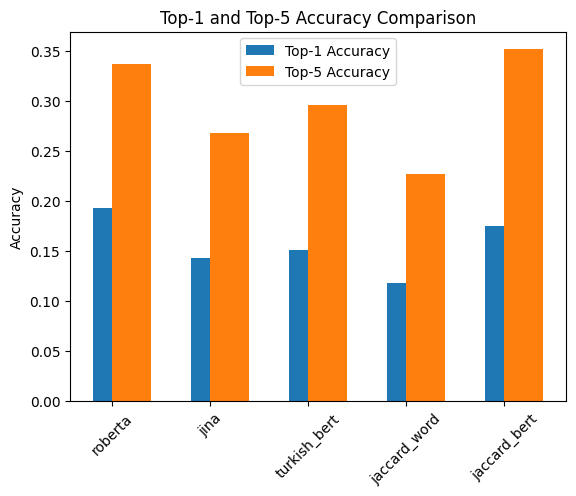

In [14]:
import matplotlib.pyplot as plt

# Top-1 ve Top-5 doğrulukları
models = list(model_results.keys())
top_1_accuracies = [model_results[model]["top_1_accuracy"] for model in models]
top_5_accuracies = [model_results[model]["top_5_accuracy"] for model in models]

# Çubuk grafik
x = range(len(models))
plt.bar(x, top_1_accuracies, width=0.4, label="Top-1 Accuracy", align='center')
plt.bar(x, top_5_accuracies, width=0.4, label="Top-5 Accuracy", align='edge')
plt.xticks(x, models, rotation=45)
plt.ylabel("Accuracy")
plt.title("Top-1 and Top-5 Accuracy Comparison")
plt.legend()
plt.show()


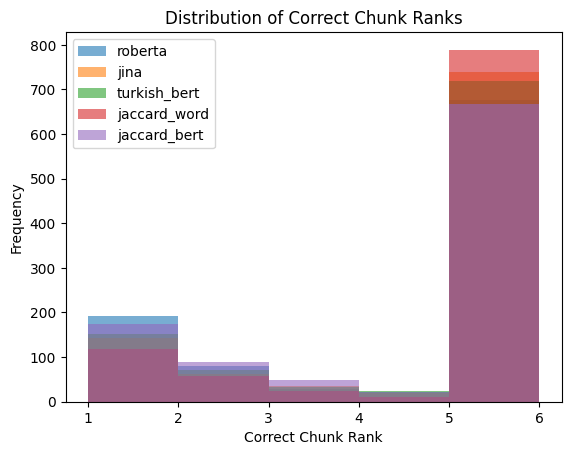

In [15]:
for model_name, results in model_results.items():
    correct_ranks = []
    for i, indices in enumerate(results["retrieved_indices"]):
        rank = np.where(indices == selected_correct_indices[i])[0]
        correct_ranks.append(rank[0] + 1 if len(rank) > 0 else len(indices) + 1)
    
    plt.hist(correct_ranks, bins=range(1, 7), alpha=0.6, label=model_name)

plt.xlabel("Correct Chunk Rank")
plt.ylabel("Frequency")
plt.title("Distribution of Correct Chunk Ranks")
plt.legend()
plt.show()


# Dorduncu Besli

In [17]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import nltk
from transformers import AutoTokenizer

nltk.download('punkt')

# Veri kümesini yükle
dataset = load_dataset("Metin/WikiRAG-TR")

# Chunk ve soru ayrıştırma
chunks = []
correct_chunk_indices = []
questions = []

for i, example in enumerate(dataset['train']):
    question_chunks = example['context'].split("\n")
    correct_index = example['correct_intro_idx']

    if len(question_chunks) == 5:
        chunks.extend(question_chunks)
        correct_chunk_indices.append(len(questions)*5 + correct_index)
        questions.append(example['question'])
    elif len(question_chunks) == 6:
        if correct_index < 5:
            selected_chunks = question_chunks[:5]
        else:
            selected_chunks = question_chunks[1:]
        if question_chunks[correct_index] not in selected_chunks:
            selected_chunks[-1] = question_chunks[correct_index]
        chunks.extend(selected_chunks)
        correct_chunk_indices.append(len(questions)*5 + selected_chunks.index(question_chunks[correct_index]))
        questions.append(example['question'])

selected_questions = questions[:1000]
selected_chunks = chunks[:5000]
selected_correct_indices = correct_chunk_indices[:1000]

print(f"Seçilen 1000 soru ve 5000 chunk hazırlandı.")

# Dense Representation Modelleri
models = {
    "multilingual_e5": SentenceTransformer('intfloat/multilingual-e5-base'),
    "bge_m3": SentenceTransformer('BAAI/bge-m3'),
    "snowflake-l-v2.0": SentenceTransformer('Snowflake/snowflake-arctic-embed-l-v2.0')
}

target_dim = 768  # Ortak boyut
model_results = {}

# --- Dense Modeller ---
for model_name, model in models.items():
    print(f"{model_name} için embedding hesaplanıyor...")
    c_emb = model.encode(selected_chunks, convert_to_tensor=False, show_progress_bar=True)
    q_emb = model.encode(selected_questions, convert_to_tensor=False, show_progress_bar=True)

    # PCA uygulama
    pca = PCA(n_components=target_dim)
    c_emb = pca.fit_transform(c_emb)
    q_emb = pca.transform(q_emb)

    # FAISS index
    d = c_emb.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(c_emb)

    # Retrieval
    print(f"{model_name} için retrieval işlemi başlatıldı...")
    distances, retrieved_indices = index.search(np.array(q_emb), k=5)

    # Performans Ölçümü
    top_1_correct = 0
    top_5_correct = 0
    for i, indices in enumerate(retrieved_indices):
        if selected_correct_indices[i] in indices[:1]:
            top_1_correct += 1
        if selected_correct_indices[i] in indices:
            top_5_correct += 1

    model_results[model_name] = {
        "retrieved_indices": retrieved_indices,
        "top_1_accuracy": top_1_correct / len(selected_questions),
        "top_5_accuracy": top_5_correct / len(selected_questions)
    }

# --- TF-IDF (normal word tokenization) ---
print("TF-IDF (word tokenization) için retrieval işlemi başlatılıyor...")
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(selected_chunks)

tfidf_all_indices = []
top_1_correct = 0
top_5_correct = 0
for i, question in enumerate(selected_questions):
    query_vector = vectorizer.transform([question])
    scores = np.dot(tfidf_matrix, query_vector.T).toarray().flatten()
    tfidf_indices = np.argsort(scores)[::-1][:5]
    tfidf_all_indices.append(tfidf_indices)

    if selected_correct_indices[i] in tfidf_indices[:1]:
        top_1_correct += 1
    if selected_correct_indices[i] in tfidf_indices:
        top_5_correct += 1

model_results["tfidf_word"] = {
    "retrieved_indices": np.array(tfidf_all_indices),
    "top_1_accuracy": top_1_correct / len(selected_questions),
    "top_5_accuracy": top_5_correct / len(selected_questions)
}

# --- TF-IDF (BERT tokenization) ---
print("TF-IDF (BERT tokenization) için retrieval işlemi başlatılıyor...")

# BERT tokenizer ile tokenize et
bert_tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

def bert_tokenize(text):
    tokens = bert_tokenizer.tokenize(text.lower())
    return " ".join(tokens)

tokenized_chunks_bert = [bert_tokenize(chunk) for chunk in selected_chunks]
vectorizer_bert = TfidfVectorizer()
tfidf_matrix_bert = vectorizer_bert.fit_transform(tokenized_chunks_bert)

bert_tfidf_all_indices = []
top_1_correct = 0
top_5_correct = 0
for i, question in enumerate(selected_questions):
    tokenized_question_bert = bert_tokenize(question)
    query_vector_bert = vectorizer_bert.transform([tokenized_question_bert])
    scores = np.dot(tfidf_matrix_bert, query_vector_bert.T).toarray().flatten()
    tfidf_indices = np.argsort(scores)[::-1][:5]
    bert_tfidf_all_indices.append(tfidf_indices)

    if selected_correct_indices[i] in tfidf_indices[:1]:
        top_1_correct += 1
    if selected_correct_indices[i] in tfidf_indices:
        top_5_correct += 1

model_results["tfidf_bert"] = {
    "retrieved_indices": np.array(bert_tfidf_all_indices),
    "top_1_accuracy": top_1_correct / len(selected_questions),
    "top_5_accuracy": top_5_correct / len(selected_questions)
}

# Tekil yöntem sonuçları
for model_name, results in model_results.items():
    print(f"{model_name} - Top-1 Accuracy: {results['top_1_accuracy']:.4f}, Top-5 Accuracy: {results['top_5_accuracy']:.4f}")

# Ensemble (Tüm dense'ler + TF-IDF (word) + TF-IDF (bert))
methods = list(model_results.keys())  # ["multilingual_e5", "bge_m3", "snowflake-l-v2.0","tfidf_word", "tfidf_bert"]

top_1_correct = 0
top_5_correct = 0

for i in range(len(selected_questions)):
    chunk_scores = {}
    for method in methods:
        retrieved_indices = model_results[method]["retrieved_indices"][i]
        for rank, c_idx in enumerate(retrieved_indices):
            score = 5 - rank  # top-1: 5 puan, top-2:4 ... top-5:1
            if c_idx not in chunk_scores:
                chunk_scores[c_idx] = 0
            chunk_scores[c_idx] += score

    sorted_chunks = sorted(chunk_scores.items(), key=lambda x: x[1], reverse=True)
    top_chunks = [x[0] for x in sorted_chunks[:5]]

    if selected_correct_indices[i] in top_chunks[:1]:
        top_1_correct += 1
    if selected_correct_indices[i] in top_chunks:
        top_5_correct += 1

ensemble_top_1_acc = top_1_correct / len(selected_questions)
ensemble_top_5_acc = top_5_correct / len(selected_questions)

print(f"Ensemble (Tüm 5 temsil) - Top-1 Accuracy: {ensemble_top_1_acc:.4f}, Top-5 Accuracy: {ensemble_top_5_acc:.4f}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Seçilen 1000 soru ve 5000 chunk hazırlandı.
multilingual_e5 için embedding hesaplanıyor...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

multilingual_e5 için retrieval işlemi başlatıldı...
bge_m3 için embedding hesaplanıyor...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

bge_m3 için retrieval işlemi başlatıldı...
snowflake-l-v2.0 için embedding hesaplanıyor...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

snowflake-l-v2.0 için retrieval işlemi başlatıldı...
TF-IDF (word tokenization) için retrieval işlemi başlatılıyor...
TF-IDF (BERT tokenization) için retrieval işlemi başlatılıyor...


Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


multilingual_e5 - Top-1 Accuracy: 0.3310, Top-5 Accuracy: 0.5330
bge_m3 - Top-1 Accuracy: 0.3130, Top-5 Accuracy: 0.5350
snowflake-l-v2.0 - Top-1 Accuracy: 0.3090, Top-5 Accuracy: 0.5290
tfidf_word - Top-1 Accuracy: 0.2860, Top-5 Accuracy: 0.4590
tfidf_bert - Top-1 Accuracy: 0.2710, Top-5 Accuracy: 0.4740
Ensemble (Tüm 5 temsil) - Top-1 Accuracy: 0.3220, Top-5 Accuracy: 0.5410


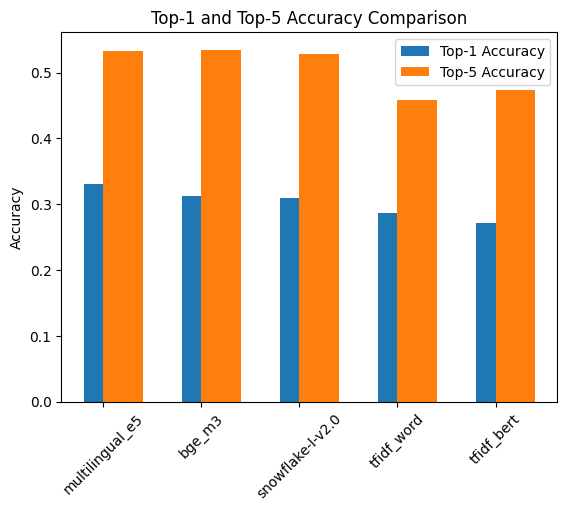

In [18]:
import matplotlib.pyplot as plt

# Top-1 ve Top-5 doğrulukları
models = list(model_results.keys())
top_1_accuracies = [model_results[model]["top_1_accuracy"] for model in models]
top_5_accuracies = [model_results[model]["top_5_accuracy"] for model in models]

# Çubuk grafik
x = range(len(models))
plt.bar(x, top_1_accuracies, width=0.4, label="Top-1 Accuracy", align='center')
plt.bar(x, top_5_accuracies, width=0.4, label="Top-5 Accuracy", align='edge')
plt.xticks(x, models, rotation=45)
plt.ylabel("Accuracy")
plt.title("Top-1 and Top-5 Accuracy Comparison")
plt.legend()
plt.show()


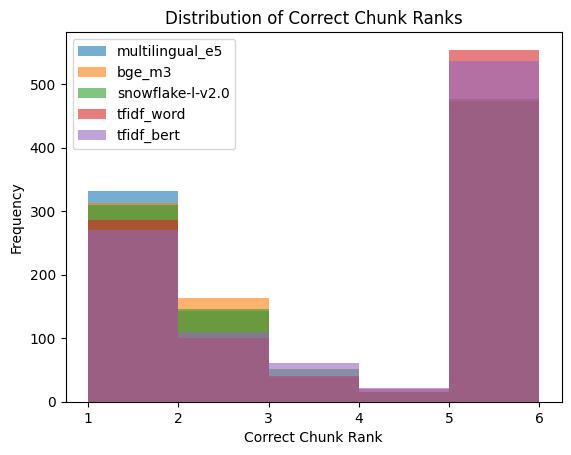

In [19]:
for model_name, results in model_results.items():
    correct_ranks = []
    for i, indices in enumerate(results["retrieved_indices"]):
        rank = np.where(indices == selected_correct_indices[i])[0]
        correct_ranks.append(rank[0] + 1 if len(rank) > 0 else len(indices) + 1)
    
    plt.hist(correct_ranks, bins=range(1, 7), alpha=0.6, label=model_name)

plt.xlabel("Correct Chunk Rank")
plt.ylabel("Frequency")
plt.title("Distribution of Correct Chunk Ranks")
plt.legend()
plt.show()
